# Deep Dream
Here, we use TensorFlow to automatically derive the gradient for a given layer in the network with respect to the input image. The gradient is then used to update the input image. This procedure is repeated a number of times for interesting patterns

In [21]:
%matplotlib inline
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
#Loading  pre trained network inception

model_fn = '/home/vijay/workspace/ml/databases/models/inception3/classify_image_graph_def.pb'
image_path = '/home/vijay/workspace/ml/databases/models/inception3/cropped_panda.jpg'
#Create a Tensorflow session ans loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(graph_def)

In [3]:
# Lets get the list of all operations in the graph

layers = [op.name for op in graph.get_operations()]
print('\nNumber of layers:', len(layers))
layers[0:20] # first few operations in the graph


Number of layers: 1004


['import/DecodeJpeg/contents',
 'import/DecodeJpeg',
 'import/Cast',
 'import/ExpandDims/dim',
 'import/ExpandDims',
 'import/ResizeBilinear/size',
 'import/ResizeBilinear',
 'import/Sub/y',
 'import/Sub',
 'import/Mul/y',
 'import/Mul',
 'import/conv/conv2d_params',
 'import/conv/Conv2D',
 'import/conv/batchnorm/beta',
 'import/conv/batchnorm/gamma',
 'import/conv/batchnorm/moving_mean',
 'import/conv/batchnorm/moving_variance',
 'import/conv/batchnorm',
 'import/conv/CheckNumerics',
 'import/conv/control_dependency']

In [225]:
# Now lets get only the tensor from the graph
tensor_name = [ graph.get_tensor_by_name(name+':0') for name in layers]
print('\nNumber of tensors:', len(tensor_name))
tensor_name[80:] #First few tensors


Number of tensors: 1004


[<tf.Tensor 'import/mixed/tower/conv/batchnorm/gamma:0' shape=(48,) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv/batchnorm/moving_mean:0' shape=(48,) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv/batchnorm/moving_variance:0' shape=(48,) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv/batchnorm:0' shape=(1, 35, 35, 48) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv/CheckNumerics:0' shape=(1, 35, 35, 48) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv/control_dependency:0' shape=(1, 35, 35, 48) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv:0' shape=(1, 35, 35, 48) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv_1/conv2d_params:0' shape=(5, 5, 48, 64) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv_1/Conv2D:0' shape=(1, 35, 35, 64) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv_1/batchnorm/beta:0' shape=(64,) dtype=float32>,
 <tf.Tensor 'import/mixed/tower/conv_1/batchnorm/gamma:0' shape=(64,) dtype=float32>,
 <tf.Tensor 'import/mixed/

There are 3 input nodes: 'import/ResizeBilinear:0' for raw data, 'DecodeJpeg/contents' for feeding the input image as jpeg and 'DecodeJpeg' for jpeg image. We will use the 'ResizeBilinear' as input, the input will be fed as raw input.

Lets see how to give a jpeg input to the 'DecodeJpeg' tensor and read the raw numbers out of the 'ResizeBilinear' tensor.

In [22]:
# Use the function get_tensor_by_name to get the actual tensor
ResizeBilinear = graph.get_tensor_by_name('import/ResizeBilinear:0')
DecodeJpeg = graph.get_tensor_by_name('import/DecodeJpeg:0')
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(layer)

image = Image.open('360.jpg')
image_array = np.array(image)[:, :, 0:3]
img = sess.run(ResizeBilinear, {DecodeJpeg: image_array})

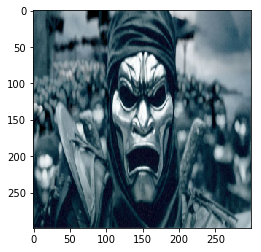

In [23]:
img = np.reshape(img, [299, 299, 3])
plt.imshow(img/255.)
plt.show()

We can see that the inputs are always scaled to 299x299. Deep Dream uses a pyramid of input gradient with a scaling factor. We need to pad zeros to get away with this problem.

In [78]:
ResizeBilinear.get_shape().as_list()

[1, 299, 299, 3]

### Lets define some helper functions

* Load a Jpeg image to a array
* plot/save image to the disk
* plot gradient

In [142]:
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

def show_image(image, filename=None):
    
    # pixel-values should be between 0 and 255 and conver to bytes
    image = np.clip(image, 0.0, 255.0).astype(np.uint8)
    
    if filename is None:
        display(Image.fromarray(image))
    else:
        with open(filename, 'wb') as file:
            PIL.Image.fromarray(image).save(file, 'jpeg')

def show_gradient(grad):
    # Normalize between 0 and 1
    grad_norm= (grad-grad.mean())/max(grad.std(), 1e-4)*0.1 + 0.5
    #grad_norm = (grad - grad.min())/(grad.max() - grad.min()) 
    
    plt.imshow(grad_norm, interpolation='bilinear')
    plt.show()

In [317]:
# Resize images 
def zoom_image(image, size):
         
    #reverse the size for PIL (widh x height is reversed in PIL vs numpy)
    size = tuple(reversed(size))
    
    img = np.clip(image, 0.0, 255.0).astype(np.uint8)    
    img = Image.fromarray(img)
    
    out = img.resize(size, PIL.Image.LANCZOS)
    return out

### Lets add the gradient of the image to a given tensor to amplify patterns in a input image

-0.148438 0.0617758 0.88705 2.19439 3.17478 4.00887 4.72082 5.29661 5.77916 6.26236 6.62881 7.11222 7.3473 7.7267 7.9149 8.27494 8.48486 8.72978 8.97957 9.13299 

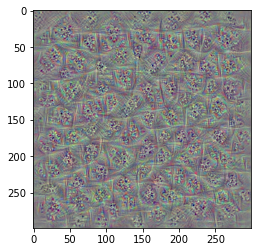

In [421]:
# Lets try to give some random noise as a image and observe the gradients
from scipy.ndimage.filters import gaussian_filter

layer = 'import/mixed_2/tower_2/conv/Conv2D:0'
img_noise = np.random.uniform(size=(1,299,299, 3)) + 100.0
channel = 100 # from the layer pick a channel
iter_n = 20
step = 1.5

#Get the tensor
tensor =  graph.get_tensor_by_name(layer)
img = img_noise
#define the gradients of input to that tensor
t_score = tf.reduce_mean(tensor1) + tf.reduce_mean(tensor2)
t_grad = tf.gradients(t_score, ResizeBilinear)[0]

#Iterate over
for i in range(iter_n):
    g, score = sess.run([t_grad, t_score], {ResizeBilinear: img})
    #show_gradient(g)
    g /= g.std()+1e-8
    sigma = 0.1
    g_blur = gaussian_filter(g.reshape(299,299,3), sigma=(sigma, sigma, 0.0)).reshape(1,299,299,3)
    img += g_blur*step
    print(score, end = ' ')
img = np.reshape(img, [299, 299, 3]) #reshape back to image size

show_gradient(img)

-0.253799 -0.130424 -0.0668977 -0.0338325 -0.00445695 0.0139254 0.0313204 0.0441339 0.0574751 0.0662767 0.0770594 0.0871126 0.0933956 0.100506 0.107773 0.114152 0.120035 0.124304 0.130593 0.13375 

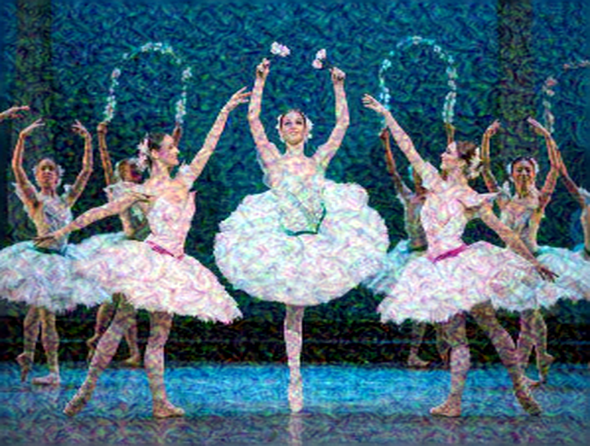

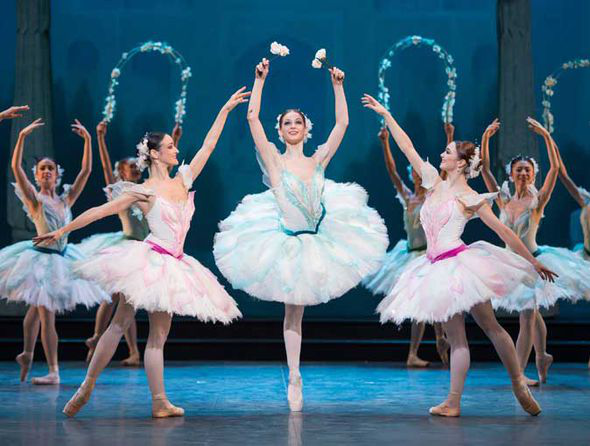

In [424]:
# Lets try for a image and observe the gradients

#layer = 'import/softmax:0'
layer1 = 'import/mixed_4/tower_2/conv/Conv2D:0'
layer2 = 'import/mixed_5/tower_2/conv/Conv2D:0'
tensor1 =  graph.get_tensor_by_name(layer)
tensor2 =  graph.get_tensor_by_name(layer)

image = Image.open('dance.jpg')
image_array = np.array(image)[:, :, 0:3]
image = sess.run(ResizeBilinear, {DecodeJpeg: image_array})
step = 4
#Get the tensor
tensor =  graph.get_tensor_by_name(layer)
#define the gradients of input to that tensor
#t_score = tf.reduce_mean(-tf.log (tf.clip_by_value(tensor, 0.2, 0.5)))
t_score = tf.reduce_mean(tf.square(tensor) )
t_grad = tf.gradients(t_score, ResizeBilinear)[0]
img = image
#Iterate over
for i in range(20):
    g, score = sess.run([t_grad, t_score], {ResizeBilinear: img})
    #show_gradient(g)
    g /= g.std()+1e-8
    #g[g<0.] = 0.
    sigma = 0.5
    g_blur = gaussian_filter(g.reshape(299,299,3), sigma=(sigma, sigma, 0.0)).reshape(1,299,299,3)
    img += g_blur*step
    print(score, end = ' ')
img = np.reshape(img, [299, 299, 3]) #reshape back to image size

show_image(zoom_image(img.reshape(299,299,3), (image_array.shape[0],image_array.shape[1])))
display(PIL.Image.fromarray(image_array))

In [344]:
layer = 'import/softmax:0'
tensor =  graph.get_tensor_by_name(layer)
out = sess.run(tensor, {DecodeJpeg: image_array})
out

array([[  4.74461413e-05,   2.87675521e-05,   1.33999638e-05, ...,
          4.74461413e-05,   4.74463668e-05,   4.74463668e-05]], dtype=float32)

In [345]:
# Resize images for Deep dream

#input tensor size for image scaling
t_in_size = ResizeBilinear.get_shape().as_list()[1] 

def resize_image(image, scale, inv=0):
    
    # resize to the new shape
    size = (np.array([t_in_size, t_in_size])/(scale)).astype('int')
    
    #reverse the size for PIL (widh x height is reversed in PIL vs numpy)
    size = tuple(reversed(size))
    
    img = np.clip(image, 0.0, 255.0).astype(np.uint8)    
    img = Image.fromarray(img)
    
    if inv is 0:
        img_t_size = img.resize([t_in_size, t_in_size], PIL.Image.LANCZOS)
        img_resized = img.resize(size, PIL.Image.LANCZOS)
        out = ImageOps.expand(img_resized, border=(t_in_size-size[0])>>1, fill='black')
    else:
        img_without_border = ImageOps.crop(img, border=(t_in_size-size[0]>>1))
        out = img_without_border.resize([t_in_size, t_in_size], PIL.Image.LANCZOS)
    
    #print('Output image size', out.size)
    return out

2.28606 2.393 2.49262 2.57876 2.66214 2.74089 2.81651 2.89122 2.95997 3.02941 3.09314 3.1577 3.21952 3.28044 3.33661 3.39638 3.45365 3.51307 3.56552 3.62121 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 2.72311 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 3.05914 

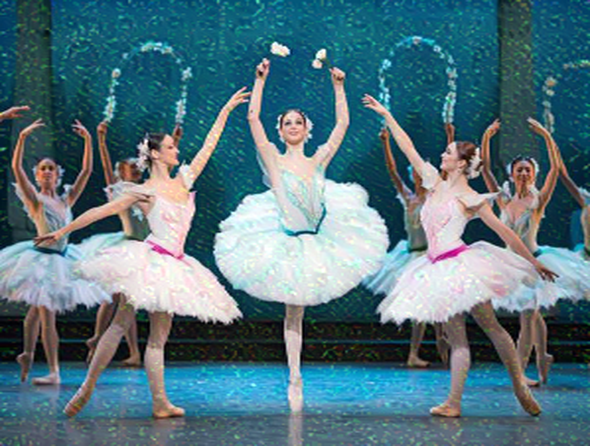

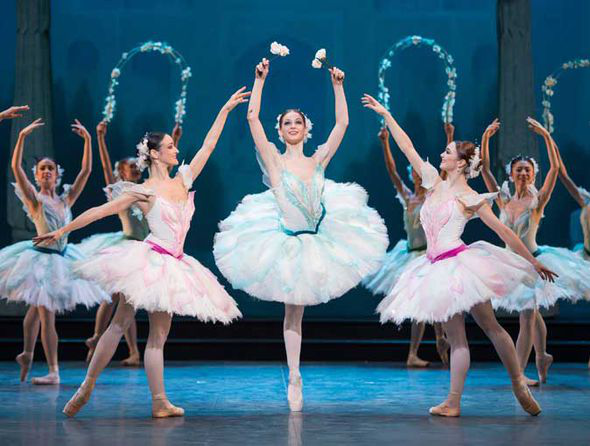

In [418]:
# Lets try image pyramids

#layer = 'import/softmax:0'
layer = 'import/mixed_2/tower_2/conv/Conv2D:0'
#layer = 'import/mixed_10/tower_1/mixed/conv:0'
tensor =  graph.get_tensor_by_name(layer)

image = Image.open('dance.jpg')
image_array = np.array(image)[:, :, 0:3]
image = sess.run(ResizeBilinear, {DecodeJpeg: image_array})
step = 1.0

#define the gradients of input to that tensor
#t_score = tf.reduce_mean(-tf.log (tf.clip_by_value(tensor, 0.4, 0.7)))
t_score = tf.reduce_mean(tf.square(tensor))
t_grad = tf.gradients(t_score, ResizeBilinear)[0]
img = np.array(image).copy()
#Iterate over

for i in range(20):
    g, score = sess.run([t_grad, t_score], {ResizeBilinear: img})
    #show_gradient(g)
    g /= g.std()+1e-8
    g[g<0.] = 0.
    sigma = .5
    g_blur = gaussian_filter(g.reshape(299,299,3), sigma=(sigma, sigma, 0.0)).reshape(1,299,299,3)
    img += g_blur*step
    print(score, end = ' ')

img = np.reshape(img, [299, 299, 3])
image = np.reshape(img, [299, 299, 3])
for scale in [1.25, 2.5]:
    img_1 = np.expand_dims(resize_image(image, scale), axis=0) 
    img = np.expand_dims(img, axis=0) 
    for i in range(20):
        g, score = sess.run([t_grad, t_score], {ResizeBilinear: img_1})
        g /= g.std()+1e-8
        g[g<0.] = 0.
        sigma = .5
        g_blur = gaussian_filter(g.reshape(299,299,3), sigma=(sigma, sigma, 0.0)).reshape(1,299,299,3)
        img_r = np.expand_dims(resize_image(np.squeeze(g), scale, 1), axis=0) 
        img += img_r*step
        print(score, end = ' ')
    del(img_1)
    
img = np.reshape(img, [299, 299, 3]) #reshape back to image size

show_image(zoom_image(img, (image_array.shape[0],image_array.shape[1])))
display(PIL.Image.fromarray(image_array))